# Triplets Extraction & Light Preprocessing 

In this notebook the following implementations are applied:

1. Denoising of Paragraphs and Light Preprocessing (Punctuation Removal, Keep Text Elements, Lower Case)
2. Triplets Extraction from Sentences that Coreference Resolution has not been applied
3. Triplets Extraction from Sentences that Coreference Resolution has been applied, using a Pipeline 
4. Use the Coreferenced Triplets Dataframe, from step 3, for further preprocessing in the next steps
5. Remove NA Values, Expand Dataframe to each Row for each Triplet
6. Lemmatize each Relation(Verb) of each Triplet and Remove Triplets were Head(Subject)=stopword 
7. Visualize Triplets using Bar plots

REMARK !!!!! -> The triplets extracted in step 2, from the sentences without coreference resolution, are not used in steps 3,4,5,6,7 and in any further analysis

# Import final_dataframe.csv and packages 

THE claucy package had to be installed from https://github.com/mmxgn/spacy-clausie and is based on the paper of ClausIE

## Import Packages & Dataframe

In [1]:
import pandas as pd
import ast
import spacy
import re
import claucy
import matplotlib.pyplot as plt
import matplotx
from wordcloud import WordCloud

In [4]:
# The previously content and cleaned content columns, contained lists, but due to csv format, they had become strings
# Thus, they are converted back to lists 

final_dataframe = pd.read_csv('final_dataframe.csv')

def convert_to_list(column):
    return column.apply(ast.literal_eval)

final_dataframe['Content'] = convert_to_list(final_dataframe['Content'])
final_dataframe['Cleaned_Content'] = convert_to_list(final_dataframe['Cleaned_Content'])

In [5]:
final_dataframe

,Title,Articles,Content,Cleaned_Content
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,[this regulation lays down the rules for the e...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,[‘applicant’ means a natural person or an enti...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,[provisions concerning the implementation of t...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,"[unless otherwise provided in this regulation,..."
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 5 Protection of personal data,[\nThis Regulation is without prejudice to Reg...,[this regulation is without prejudice to regul...
...,...,...,...,...
277,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 278 Amendment to Decision No 541/2014...,[\nIn Article 4 of Decision No 541/2014/EU of ...,[in article 4 of decision no 541/2014/eu of th...
278,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 279 Transitional provisions,[ \nLegal commitments for grants implementing ...,[legal commitments for grants implementing the...
279,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 280 Review,[\nThis Regulation shall be reviewed whenever ...,[this regulation shall be reviewed whenever it...
280,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 281 Repeal,"[ \nRegulation (EU, Euratom) No 966/2012 is re...","[regulation (eu, euratom) no 966/2012 is repea..."


In [6]:
final_dataframe.iloc[6,3]

['for each financial year, the budget shall forecast and authorise all revenue and expenditure considered necessary for the union. it shall comprise: (a) the revenue and expenditure of the union, including administrative expenditure resulting from the implementation of the provisions of the teu relating to the common foreign and security policy (cfsp), and operational expenditure occasioned by implementation of those provisions where it is charged to the budget; (b) the revenue and expenditure of the european atomic energy community.',
 'the budget shall contain differentiated appropriations, which consist of commitment appropriations and payment appropriations, and non-differentiated appropriations. the appropriations authorised for the financial year shall consist of: (a) appropriations provided in the budget, including by amending budgets; (b) appropriations carried over from preceding financial years; (c) appropriations made available again in accordance with article 15; (d) approp

In [7]:
final_dataframe["Articles"].unique()

array(['Article 1  Subject matter ', 'Article 2  Definitions ',
       'Article 3  Compliance of secondary legislation with this Regulation ',
       'Article 4  Periods, dates and time limits ',
       'Article 5  Protection of personal data ',
       'Article 6  Respect for budgetary principles ',
       'Article 7  Scope of the budget ',
       'Article 8  Specific rules on the principles of unity and budgetary accuracy ',
       'Article 9  Definition ',
       'Article 10  Budgetary accounting for revenue and appropriations ',
       'Article 11  Commitment of appropriations ',
       'Article 12  Cancellation and carry-over of appropriations ',
       'Article 13  Detailed provisions on cancellation and carry-over of appropriations ',
       'Article 14  Decommitments ',
       'Article 15  Making appropriations corresponding to decommitments available again ',
       'Article 16  Rules applicable in the event of late adoption of the budget ',
       'Article 17  Definition and s

In [8]:
final_dataframe[final_dataframe["Articles"]=="Article 100  Authorisation of recovery "].iloc[0,3]

['the authorising officer responsible shall, by issuing a recovery order, instruct the accounting officer to recover an amount receivable which that authorising officer responsible has established (‘the authorisation of recovery’).',
 'a union institution may formally establish an amount as being receivable from persons other than member states by means of a decision which shall be enforceable within the meaning of article 299 tfeu. if the efficient and timely protection of the financial interests of the union so requires, other union institutions may, in exceptional circumstances, request the commission to adopt such an enforceable decision for their benefit with respect to claims arising in relation to staff or in relation to members or former members of a union institution, provided that those institutions have agreed with the commission on the practical modalities for the application of this article. such exceptional circumstances shall be deemed to exist when there is no prospect 

In [9]:
final_dataframe.shape

(282, 4)

In [10]:
final_dataframe

,Title,Articles,Content,Cleaned_Content
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,[this regulation lays down the rules for the e...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,[‘applicant’ means a natural person or an enti...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,[provisions concerning the implementation of t...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,"[unless otherwise provided in this regulation,..."
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 5 Protection of personal data,[\nThis Regulation is without prejudice to Reg...,[this regulation is without prejudice to regul...
...,...,...,...,...
277,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 278 Amendment to Decision No 541/2014...,[\nIn Article 4 of Decision No 541/2014/EU of ...,[in article 4 of decision no 541/2014/eu of th...
278,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 279 Transitional provisions,[ \nLegal commitments for grants implementing ...,[legal commitments for grants implementing the...
279,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 280 Review,[\nThis Regulation shall be reviewed whenever ...,[this regulation shall be reviewed whenever it...
280,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 281 Repeal,"[ \nRegulation (EU, Euratom) No 966/2012 is re...","[regulation (eu, euratom) no 966/2012 is repea..."


In [11]:
dataframe_I = final_dataframe[final_dataframe["Title"]=='TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES ']
dataframe_I.shape

(5, 4)

In [12]:
dataframe_I

,Title,Articles,Content,Cleaned_Content
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,[this regulation lays down the rules for the e...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,[‘applicant’ means a natural person or an enti...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,[provisions concerning the implementation of t...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,"[unless otherwise provided in this regulation,..."
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 5 Protection of personal data,[\nThis Regulation is without prejudice to Reg...,[this regulation is without prejudice to regul...


# Expand the Dataframe: Row for each paragraph of an article

In [13]:
# Each text paragraph for each article gets its own row 
# Expand the dataframe by creating a row for each element of each cleaned content list 

dataframe_I = dataframe_I.explode('Cleaned_Content')
dataframe_I

,Title,Articles,Content,Cleaned_Content
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘applicant’ means a natural person or an entit...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,"‘application document’ means a tender, a reque..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘award procedure’ means a procurement procedur...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,"‘basic act’ means a legal act, other than a re..."
...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘works contract’ means a contract covering eit...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,"without prejudice to paragraph 1, any proposal..."
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,"unless otherwise provided in this regulation, ..."


In [14]:
dataframe_I.iloc[4,3]

'‘basic act’ means a legal act, other than a recommendation or an opinion, which provides a legal basis for an action and for the implementation of the corresponding expenditure entered in the budget or of the budgetary guarantee or financial assistance backed by the budget, and which may take any of the following forms: (a) in implementation of the treaty on the functioning of the european union (tfeu) and the treaty establishing the european atomic energy community (the euratom treaty), the form of a regulation, a directive or a decision within the meaning of article 288 tfeu; or (b) in implementation of title v of the treaty on european union (teu), one of the forms specified in articles 28(1) and 31(2), article 33, and articles 42(4) and 43(2) teu;'

In [15]:
dataframe_I["Articles"].unique()

array(['Article 1  Subject matter ', 'Article 2  Definitions ',
       'Article 3  Compliance of secondary legislation with this Regulation ',
       'Article 4  Periods, dates and time limits ',
       'Article 5  Protection of personal data '], dtype=object)

In [16]:
dataframe_I[dataframe_I['Articles']=="Article 2  Definitions "]["Cleaned_Content"].iloc[9,]

'‘building contract’ means a contract covering the purchase, exchange, long lease, usufruct, leasing, rental or hire purchase, with or without option to buy, of land, buildings or other immovable property. it covers both existing buildings and buildings before completion provided that the candidate has obtained a valid building permit for it. it does not cover buildings designed in accordance with the specifications of the contracting authority that are covered by works contracts;'

# Text Preprocessing for each paragraph of each article (cleaned content)

-Remove instances of (a),(b),(c) Example:  ....(a) in implementation of the treaty on the functioning of the european union...(b)....(c)

-Remove punctuation except from dots as they are used for further segmentation 

-Segment the content on the dot --> Create a row for each sentence or small text chunk, and store in new column, named cleaned_content_new 


In [17]:
dataframe_I

,Title,Articles,Content,Cleaned_Content
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘applicant’ means a natural person or an entit...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,"‘application document’ means a tender, a reque..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘award procedure’ means a procurement procedur...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,"‘basic act’ means a legal act, other than a re..."
...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘works contract’ means a contract covering eit...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,"without prejudice to paragraph 1, any proposal..."
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,"unless otherwise provided in this regulation, ..."


In [18]:
# Example text before removal 

repr(dataframe_I.iloc[4,3])

"'‘basic act’ means a legal act, other than a recommendation or an opinion, which provides a legal basis for an action and for the implementation of the corresponding expenditure entered in the budget or of the budgetary guarantee or financial assistance backed by the budget, and which may take any of the following forms: (a) in implementation of the treaty on the functioning of the european union (tfeu) and the treaty establishing the european atomic energy community (the euratom treaty), the form of a regulation, a directive or a decision within the meaning of article 288 tfeu; or (b) in implementation of title v of the treaty on european union (teu), one of the forms specified in articles 28(1) and 31(2), article 33, and articles 42(4) and 43(2) teu;'"

In [19]:
# remove instances of (a),(b) etc using general expression
pattern_a = r'\s\([a-z]\)'

example_text = dataframe_I.iloc[4,3]

example_text = re.sub(pattern_a, '', example_text)


In [20]:
# Example text after removal 

example_text

'‘basic act’ means a legal act, other than a recommendation or an opinion, which provides a legal basis for an action and for the implementation of the corresponding expenditure entered in the budget or of the budgetary guarantee or financial assistance backed by the budget, and which may take any of the following forms: in implementation of the treaty on the functioning of the european union (tfeu) and the treaty establishing the european atomic energy community (the euratom treaty), the form of a regulation, a directive or a decision within the meaning of article 288 tfeu; or in implementation of title v of the treaty on european union (teu), one of the forms specified in articles 28(1) and 31(2), article 33, and articles 42(4) and 43(2) teu;'

## Function for Punctuation and Noise Removal 

In [21]:
# Remove punctuation function BUT without removing dots (.) for possible future segmentation 

def remove_punct(text):
    pattern_a = r'\s\([a-z]\)'
    text = re.sub(pattern_a, '', text)
    cleaned = ""
    punctuation = '!@#$%^&*_-+={}[];"\'|<>,?/~`’‘'
    for i in text:
        if i not in punctuation:
            cleaned = cleaned + i 
    return cleaned.strip()

In [22]:
dataframe_I

,Title,Articles,Content,Cleaned_Content
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘applicant’ means a natural person or an entit...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,"‘application document’ means a tender, a reque..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘award procedure’ means a procurement procedur...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,"‘basic act’ means a legal act, other than a re..."
...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,‘works contract’ means a contract covering eit...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,"without prejudice to paragraph 1, any proposal..."
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,"unless otherwise provided in this regulation, ..."


In [23]:
dataframe_I[dataframe_I["Articles"]=="Article 4  Periods, dates and time limits "].iloc[0,3]


'unless otherwise provided in this regulation, council regulation (eec, euratom) no 1182/71 ( 1 ) shall apply to the deadlines set out in this regulation. l 193/30    1).'

### Apply Punctuation and Noise Removal Function

In [24]:
# Remove punctuation (not .) from cleaned content column 

dataframe_I['Cleaned_Content'] = dataframe_I['Cleaned_Content'].apply(remove_punct)

In [25]:
dataframe_I.iloc[14,3].split(".")

['concession contract means a contract for pecuniary interest concluded in writing between one or more economic operators and one or more contracting authorities within the meaning of articles 174 and 178 in order to entrust the execution of works or the provision and management of services to an economic operator (the concession) and where: the remuneration consists either solely in the right to exploit the works or services or in that right together with payment the award of the concession contract involves the transfer to the concessionaire of an operating risk in exploiting those works or services encompassing demand risk or supply risk or both',
 ' the concessionaire shall be deemed to assume an operating risk where under normal operating conditions there is no guarantee of recouping the investments made or the costs incurred in operating the works or the services concerned']

In [26]:
dataframe_I.iloc[4,3]

'basic act means a legal act other than a recommendation or an opinion which provides a legal basis for an action and for the implementation of the corresponding expenditure entered in the budget or of the budgetary guarantee or financial assistance backed by the budget and which may take any of the following forms: in implementation of the treaty on the functioning of the european union (tfeu) and the treaty establishing the european atomic energy community (the euratom treaty) the form of a regulation a directive or a decision within the meaning of article 288 tfeu or in implementation of title v of the treaty on european union (teu) one of the forms specified in articles 28(1) and 31(2) article 33 and articles 42(4) and 43(2) teu'

#### Convert Cleaned Content into a List

In [27]:
# Create new column of sentences or small text chunks 

dataframe_I['Cleaned_Content_new'] = dataframe_I['Cleaned_Content'].apply(lambda x: x.split('.'))

In [28]:
dataframe_I

,Title,Articles,Content,Cleaned_Content,Cleaned_Content_new
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,[this regulation lays down the rules for the e...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,[applicant means a natural person or an entity...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,[application document means a tender a request...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,[award procedure means a procurement procedure...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,[basic act means a legal act other than a reco...
...,...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,works contract means a contract covering eithe...,[works contract means a contract covering eith...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...,[provisions concerning the implementation of t...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,without prejudice to paragraph 1 any proposal ...,[without prejudice to paragraph 1 any proposal...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,unless otherwise provided in this regulation c...,[unless otherwise provided in this regulation ...


In [29]:
# Example of empty elements problem 

dataframe_I.iloc[0,4]

['this regulation lays down the rules for the establishment and the implementation of the general budget of the european union and of the european atomic energy community (the budget) and the presentation and auditing of their accounts',
 '']

## Function to Keep only the text elements of each articles content list

In [30]:
# Function to only keep text elements that are NOT empty or are NOT single characters or single numbers 

def keep_text_elements(text_list):
    cleaned_text_list = []
    if isinstance(text_list,list):
        for element in text_list:
            if len(re.findall(r'[a-zA-Z]', element)) > 1:
                cleaned_text_list.append(element)
    return cleaned_text_list


In [31]:
keep_text_elements(dataframe_I.iloc[0,4])

['this regulation lays down the rules for the establishment and the implementation of the general budget of the european union and of the european atomic energy community (the budget) and the presentation and auditing of their accounts']

### Apply keep text only function

In [32]:
# Apply the function to cleaned content new 

dataframe_I['Cleaned_Content_new'] = dataframe_I['Cleaned_Content_new'].apply(keep_text_elements)

In [33]:
dataframe_I

,Title,Articles,Content,Cleaned_Content,Cleaned_Content_new
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,[this regulation lays down the rules for the e...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,[applicant means a natural person or an entity...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,[application document means a tender a request...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,[award procedure means a procurement procedure...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,[basic act means a legal act other than a reco...
...,...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,works contract means a contract covering eithe...,[works contract means a contract covering eith...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...,[provisions concerning the implementation of t...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,without prejudice to paragraph 1 any proposal ...,[without prejudice to paragraph 1 any proposal...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,unless otherwise provided in this regulation c...,[unless otherwise provided in this regulation ...


# Expand Dataframe - Row for each Sentence or Small Text Chunk

In [34]:
# Row for each sentence or small text chunk in the list of the cleaned (punctuation, noise, lowercase) text

dataframe_I = dataframe_I.explode('Cleaned_Content_new')
dataframe_I

,Title,Articles,Content,Cleaned_Content,Cleaned_Content_new
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...
...,...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,works contract means a contract covering eithe...,works contract means a contract covering eithe...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...,provisions concerning the implementation of th...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,without prejudice to paragraph 1 any proposal ...,without prejudice to paragraph 1 any proposal ...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,unless otherwise provided in this regulation c...,unless otherwise provided in this regulation c...


In [35]:
dataframe_I[dataframe_I["Articles"]=='Article 3  Compliance of secondary legislation with this Regulation '].iloc[0,3]

'provisions concerning the implementation of the revenue and expenditure of the budget and contained in a basic act shall comply with the budgetary principles set out in title ii.'

# Obtain triplets of Subject-Verb-Object - No Coreference Resolution Applied - Use of Dataframe without Coreferenced Sentences

- Apply a Rule-Based Method (ClausIE), specifically the algorithm mentioned in the relevant paper



## Example: ClausIE Propositions Extraction 

In [36]:
import claucy

nlp = spacy.load("en_core_web_sm")
claucy.add_to_pipe(nlp)

doc = nlp('basic act means a legal act, other than a recommendation or an opinion, which provides a legal basis for an action and for the implementation of the corresponding expenditure entered in the budget or of the budgetary guarantee or financial assistance backed by the budget, and which may take any of the following forms')

propositions = doc._.clauses
propositions

# triplet = [str(propositions.subject),str(propositions.verb),str(propositions.direct_object) +  " " + str(propositions.complement) + str(propositions.adverbials[0])]
# print(triplet)

[<SVO, basic act, means, None, a legal act, other than a recommendation or an opinion, which provides a legal basis for an action and for the implementation of the corresponding expenditure entered in the budget or of the budgetary guarantee or financial assistance backed by the budget,, None, []>,
 <SVO, which, provides, None, a legal basis for an action and for the implementation of the corresponding expenditure entered in the budget or of the budgetary guarantee or financial assistance backed by the budget, None, []>,
 <SVO, which, may take, None, any of the following forms, None, []>]

## Define Triplet Extraction from Propositions Function

In [37]:
# Only keep proposition elements that were detected 

def triplet(propos):
    triplet = []
    tail = ''
    if propos.subject != None:
        triplet.append(str(propos.subject))
    if propos.verb != None:
        triplet.append(str(propos.verb))
    if propos.direct_object != None:
        tail = tail + str(propos.direct_object)
    if propos.complement != None:
        tail = tail + " " + str(propos.complement)
    if len(propos.adverbials) != 0:
        adverbial = ""
        for i in propos.adverbials:
            adverbial = adverbial + " " + str(i)
        adverbial = adverbial.strip()
        tail = tail + " " + adverbial.strip()
    triplet.append(tail)
    
    return triplet


def all_triplets(propositions_list):
    triplet_list = []
    for proposition in propositions_list:
        if len(triplet(proposition))==3:
            triplet_list.append(triplet(proposition))
    return triplet_list       


def obtain_proposition_list(complex_sentence):
    import claucy

    nlp = spacy.load("en_core_web_sm")
    claucy.add_to_pipe(nlp)

    doc = nlp(complex_sentence)

    propositions = doc._.clauses

    return all_triplets(propositions)


## Obtain Triplets from each Sentence or Small Text Chunk

In [38]:
dataframe_I['triplets_list'] = dataframe_I['Cleaned_Content_new'].apply(obtain_proposition_list)

In [39]:
dataframe_I

,Title,Articles,Content,Cleaned_Content,Cleaned_Content_new,triplets_list
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[[this regulation, lays, the rules for the est..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[[applicant, means, a natural person or an ent..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[[application document, means, a tender]]"
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[[award procedure, means, a procurement proced..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[[basic act, means, a legal act other than a r..."
...,...,...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,works contract means a contract covering eithe...,works contract means a contract covering eithe...,"[[works contract, means, a contract covering e..."
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...,provisions concerning the implementation of th...,[[provisions concerning the implementation of ...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,without prejudice to paragraph 1 any proposal ...,without prejudice to paragraph 1 any proposal ...,[]
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,unless otherwise provided in this regulation c...,unless otherwise provided in this regulation c...,[]


### Identify & Remove Empty Triplets

- Only 2 Empty Triplets Identified

In [40]:
dataframe_I['empty_list'] = dataframe_I['triplets_list'].apply(lambda x: len(x)==0)
dataframe_I['empty_list'].sum()

np.int64(2)

In [41]:
dataframe_I['empty_list'].sum()

np.int64(2)

In [43]:
dataframe_I = dataframe_I[dataframe_I['empty_list']==False]

In [44]:
dataframe_I.iloc[0,5]

[['this regulation', 'lays', 'the rules for the establishment']]

### Identify Sentences where more than 1 triplet were extracted by ClausIE

- 40 Sentences had more than 1 triplet 

In [45]:
dataframe_I['many_triplets'] = dataframe_I['triplets_list'].apply(lambda x: len(x)>1)
dataframe_I['many_triplets'].sum()

C:\Users\Student\AppData\Local\Temp\ipykernel_2932\4009133928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_I['many_triplets'] = dataframe_I['triplets_list'].apply(lambda x: len(x)>1)


np.int64(40)

In [46]:
dataframe_I['many_triplets'].sum()

np.int64(40)

In [47]:
dataframe_I

,Title,Articles,Content,Cleaned_Content,Cleaned_Content_new,triplets_list,empty_list,many_triplets
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[[this regulation, lays, the rules for the est...",False,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[[applicant, means, a natural person or an ent...",False,True
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[[application document, means, a tender]]",False,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[[award procedure, means, a procurement proced...",False,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[[basic act, means, a legal act other than a r...",False,True
...,...,...,...,...,...,...,...,...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,volunteer means a person working on a noncompu...,volunteer means a person working on a noncompu...,"[[volunteer, means, a person working on a nonc...",False,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,work means the outcome of building or civil en...,work means the outcome of building or civil en...,"[[work, means, the outcome of building or civi...",False,True
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,works contract means a contract covering eithe...,works contract means a contract covering eithe...,"[[works contract, means, a contract covering e...",False,False
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...,provisions concerning the implementation of th...,[[provisions concerning the implementation of ...,False,False


In [48]:
final_dataframe["Title"].unique()

array(['TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES ',
       'TITLE II \nBUDGET AND BUDGETARY PRINCIPLES ',
       'TITLE III \nESTABLISHMENT AND STRUCTURE OF THE BUDGET ',
       'TITLE IV \nBUDGET IMPLEMENTATION ', 'TITLE V \nCOMMON RULES ',
       'TITLE VI \nINDIRECT MANAGEMENT ',
       'TITLE VII \nPROCUREMENT AND CONCESSIONS ', 'TITLE VIII \nGRANTS ',
       'TITLE IX \nPRIZES ',
       'TITLE X \nFINANCIAL INSTRUMENTS, BUDGETARY GUARANTEES AND FINANCIAL ASSISTANCE ',
       'TITLE XI \nCONTRIBUTIONS TO EUROPEAN POLITICAL PARTIES ',
       'TITLE XII \nOTHER BUDGET IMPLEMENTATION INSTRUMENTS ',
       'TITLE XIII \nANNUAL ACCOUNTS AND OTHER FINANCIAL REPORTING ',
       'TITLE XIV \nEXTERNAL AUDIT AND DISCHARGE ',
       'TITLE XV \nADMINISTRATIVE APPROPRIATIONS ',
       'TITLE XVI \nINFORMATION REQUESTS AND DELEGATED ACTS '],
      dtype=object)

In [49]:
dataframe_II = final_dataframe[final_dataframe["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES ']

In [50]:
dataframe_II

,Title,Articles,Content,Cleaned_Content
5,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 6 Respect for budgetary principles,[\nThe budget shall be established and impleme...,[the budget shall be established and implement...
6,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 7 Scope of the budget,"[ \nFor each financial year, the budget shall ...","[for each financial year, the budget shall for..."
7,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 8 Specific rules on the principles of...,[ \nAll revenue and expenditure shall be booke...,[all revenue and expenditure shall be booked t...
8,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 9 Definition,[\nThe appropriations entered in the budget sh...,[the appropriations entered in the budget shal...
9,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 10 Budgetary accounting for revenue a...,[ \nThe revenue of a financial year shall be e...,[the revenue of a financial year shall be ente...
10,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 11 Commitment of appropriations,[ \nThe appropriations entered in the budget m...,[the appropriations entered in the budget may ...
11,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 12 Cancellation and carry-over of app...,[ \nAppropriations which have not been used by...,[appropriations which have not been used by th...
12,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 13 Detailed provisions on cancellatio...,[ \nThe commitment appropriations and the non-...,[the commitment appropriations and the non-dif...
13,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 14 Decommitments,[ \nWhere budgetary commitments are decommitte...,[where budgetary commitments are decommitted i...
14,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 15 Making appropriations correspondin...,[ \nThe appropriations corresponding to decomm...,[the appropriations corresponding to decommitm...


In [51]:
dataframe_II = dataframe_II.explode("Cleaned_Content")

In [52]:
dataframe_II = dataframe_II.reset_index(drop=True)

# Obtain triplets of Subject-Verb-Object - Coreference Resolution Applied - Use of Coreferenced Dataframe with Coreferenced Sentences

- Pipeline for Triplet Extraction from all Titles using rule-based clausIE method using the coreferenced dataframe 
- The pronouns in the sentences of the articles of this dataframe, have been replaced by the entities in the text that refer to them

In [53]:
final_dataframe

,Title,Articles,Content,Cleaned_Content
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,[this regulation lays down the rules for the e...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,[‘applicant’ means a natural person or an enti...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,[provisions concerning the implementation of t...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,"[unless otherwise provided in this regulation,..."
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 5 Protection of personal data,[\nThis Regulation is without prejudice to Reg...,[this regulation is without prejudice to regul...
...,...,...,...,...
277,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 278 Amendment to Decision No 541/2014...,[\nIn Article 4 of Decision No 541/2014/EU of ...,[in article 4 of decision no 541/2014/eu of th...
278,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 279 Transitional provisions,[ \nLegal commitments for grants implementing ...,[legal commitments for grants implementing the...
279,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 280 Review,[\nThis Regulation shall be reviewed whenever ...,[this regulation shall be reviewed whenever it...
280,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 281 Repeal,"[ \nRegulation (EU, Euratom) No 966/2012 is re...","[regulation (eu, euratom) no 966/2012 is repea..."


## Import Coreference Resolution Dataframe 

- The pronouns in the sentences of the articles of these dataframe, have been replaced by the entities in the text that refer to them

In [55]:
final_dataframe = pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\coreferenced_final_dataframe.csv')


In [56]:
final_dataframe = final_dataframe[["Title","Articles","Content","coreference_list_ready"]]
final_dataframe

,Title,Articles,Content,coreference_list_ready
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,['\nThis Regulation lays down the rules for th...,['this regulation lays down the rules for the ...
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[' ‘applicant’ means a natural person or an en...,['‘applicant’ means a natural person or an ent...
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[' \nProvisions concerning the implementation ...,['provisions concerning the implementation of ...
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",['\nUnless otherwise provided in this Regulati...,['unless otherwise provided in this regulation...
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 5 Protection of personal data,['\nThis Regulation is without prejudice to Re...,['this regulation is without prejudice to regu...
...,...,...,...,...
277,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 278 Amendment to Decision No 541/2014...,['\nIn Article 4 of Decision No 541/2014/EU of...,['in article 4 of decision no 541/2014/eu of t...
278,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 279 Transitional provisions,[' \nLegal commitments for grants implementing...,['legal commitments for grants implementing th...
279,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 280 Review,['\nThis Regulation shall be reviewed whenever...,['this regulation shall be reviewed whenever t...
280,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 281 Repeal,"[' \nRegulation (EU, Euratom) No 966/2012 is r...","['regulation (eu, euratom) no 966/2012 is repe..."


In [57]:
def convert_to_list(column):
    return column.apply(ast.literal_eval)

final_dataframe['Content'] = convert_to_list(final_dataframe['Content'])
final_dataframe['coreference_list_ready'] = convert_to_list(final_dataframe['coreference_list_ready'])

## Define Cleaning and Triplets Extraction Functions

In [58]:
def remove_punct(text):
    pattern_a = r'\s\([a-z]\)'
    text = re.sub(pattern_a, '', text)
    cleaned = ""
    punctuation = '!@#$%^&*_-+={}[];"\'|<>,?/~`’‘'
    for i in text:
        if i not in punctuation:
            cleaned = cleaned + i 
    return cleaned.strip()

def keep_text_elements(text_list):
    cleaned_text_list = []
    if isinstance(text_list,list):
        for element in text_list:
            if len(re.findall(r'[a-zA-Z]', element)) > 1:
                cleaned_text_list.append(element)
    return cleaned_text_list

def triplet(propos):
    triplet = []
    tail = ''
    if propos.subject != None:
        triplet.append(str(propos.subject))
    if propos.verb != None:
        triplet.append(str(propos.verb))
    if propos.direct_object != None:
        tail = tail + str(propos.direct_object)
    if propos.complement != None:
        tail = tail + " " + str(propos.complement)
    if len(propos.adverbials) != 0:
        adverbial = ""
        for i in propos.adverbials:
            adverbial = adverbial + " " + str(i)
        adverbial = adverbial.strip()
        tail = tail + " " + adverbial.strip()
    triplet.append(tail)
    
    return triplet


def all_triplets(propositions_list):
    triplet_list = []
    for proposition in propositions_list:
        triplet_instance = triplet(proposition)
        k = False
        for i in triplet_instance:
            if len(i)==1:
                k = True
        if len(triplet_instance)==3 and not k and '' not in triplet_instance:
            triplet_list.append(triplet(proposition))
    if len(triplet_list) != 0:
       return triplet_list       


def obtain_proposition_list(complex_sentence):
    import claucy

    nlp = spacy.load("en_core_web_sm")
    claucy.add_to_pipe(nlp)

    doc = nlp(complex_sentence)

    propositions = doc._.clauses

    return all_triplets(propositions)

## Apply a Preprocessing and Triplets Extraction Pipeline, based on the above functions

In [60]:
import time


titles_list = []
for title in final_dataframe["Title"].unique():
    start_time = time.time()
    dataframe_title = final_dataframe[final_dataframe["Title"]==title].explode('coreference_list_ready')
    dataframe_title['coreference_list_ready'] = dataframe_title['coreference_list_ready'].apply(remove_punct)
    dataframe_title['Cleaned_Content_new'] = dataframe_title['coreference_list_ready'].apply(lambda x: x.split('.'))
    dataframe_title['Cleaned_Content_new'] = dataframe_title['Cleaned_Content_new'].apply(keep_text_elements)
    dataframe_title = dataframe_title.explode('Cleaned_Content_new')
    dataframe_title['triplets_list'] = dataframe_title['Cleaned_Content_new'].apply(obtain_proposition_list)
    titles_list.append(dataframe_title)
    elapsed_time = time.time() - start_time
    print(f"Processed title '{title}' in {elapsed_time:.2f} seconds.")

triplets_dataframe = pd.concat(titles_list, ignore_index=True, axis=0)
triplets_dataframe



Processed title 'TITLE I 
SUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES ' in 95.10 seconds.
Processed title 'TITLE II 
BUDGET AND BUDGETARY PRINCIPLES ' in 260.79 seconds.
Processed title 'TITLE III 
ESTABLISHMENT AND STRUCTURE OF THE BUDGET ' in 113.33 seconds.


KeyboardInterrupt: 

## Save CSV - triplets_dataframe.csv

In [ ]:
# triplets_dataframe.to_csv('triplets_dataframe.csv', index=False)  

# Use the Above Saved Coreferenced Triplets Dataframe

- Remove NA values
- Expand Dataframe to one row for each triplet
- Remove Stopwords from Head (Subject) of each SVO triplet
- Lemmatize the Relation (Verb) of each SVO triplet
- Create visualizations (bar plots)

## Import Dataframe of Extracted Coreferenced Triplets

In [23]:
# Load triplets dataframe 
triplets_dataframe= pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplets_dataframe.csv')

In [24]:
triplets_dataframe

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,['\nThis Regulation lays down the rules for th...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[['this regulation', 'lays', 'the rules for th..."
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[' ‘applicant’ means a natural person or an en...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[['applicant', 'means', 'a natural person or a..."
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[' ‘applicant’ means a natural person or an en...,application document means a tender a request ...,application document means a tender a request ...,"[['application document', 'means', 'a tender a..."
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[' ‘applicant’ means a natural person or an en...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[['award procedure', 'means', 'a procurement p..."
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[' ‘applicant’ means a natural person or an en...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[['basic act', 'means', 'a legal act other tha..."
...,...,...,...,...,...,...
2391,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[' \nThis Regulation shall enter into force on...,by way of derogation from paragraph 2 of this ...,this regulation shall be binding in this regu...,"[['this regulation', 'be', ' binding in this r..."
2392,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[' \nThis Regulation shall enter into force on...,by way of derogation from paragraph 2 of this ...,done at brussels 18 july 2018,NaN
2393,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[' \nThis Regulation shall enter into force on...,by way of derogation from paragraph 2 of this ...,for the european parliament the president a,NaN
2394,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[' \nThis Regulation shall enter into force on...,by way of derogation from paragraph 2 of this ...,tajani for the council the president j,NaN


In [98]:
triplets_dataframe.iloc[0,2]

"['\\nThis Regulation lays down the rules for the establishment and the implementation of the general budget of the European \\nUnion and of the European Atomic Energy Community (‘the budget’) and the presentation and auditing of their accounts. ']"

## Remove NA values

In [99]:
triplets_dataframe.isna().sum()

Title                       0
Articles                    0
Content                     0
coreference_list_ready      0
Cleaned_Content_new         0
triplets_list             173
dtype: int64

In [25]:
triplets_dataframe_cleaned = triplets_dataframe.dropna()

In [26]:
def convert_to_list(column):
    return column.apply(ast.literal_eval)

triplets_dataframe_cleaned['Content'] = convert_to_list(triplets_dataframe_cleaned['Content'])
triplets_dataframe_cleaned['triplets_list'] = convert_to_list(triplets_dataframe_cleaned['triplets_list'])

C:\Users\Student\AppData\Local\Temp\ipykernel_9492\950390277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_dataframe_cleaned['Content'] = convert_to_list(triplets_dataframe_cleaned['Content'])
C:\Users\Student\AppData\Local\Temp\ipykernel_9492\950390277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_dataframe_cleaned['triplets_list'] = convert_to_list(triplets_dataframe_cleaned['triplets_list'])


In [102]:
triplets_dataframe_cleaned['Title'].unique()

array(['TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES ',
       'TITLE II \nBUDGET AND BUDGETARY PRINCIPLES ',
       'TITLE III \nESTABLISHMENT AND STRUCTURE OF THE BUDGET ',
       'TITLE IV \nBUDGET IMPLEMENTATION ', 'TITLE V \nCOMMON RULES ',
       'TITLE VI \nINDIRECT MANAGEMENT ',
       'TITLE VII \nPROCUREMENT AND CONCESSIONS ', 'TITLE VIII \nGRANTS ',
       'TITLE IX \nPRIZES ',
       'TITLE X \nFINANCIAL INSTRUMENTS, BUDGETARY GUARANTEES AND FINANCIAL ASSISTANCE ',
       'TITLE XI \nCONTRIBUTIONS TO EUROPEAN POLITICAL PARTIES ',
       'TITLE XII \nOTHER BUDGET IMPLEMENTATION INSTRUMENTS ',
       'TITLE XIII \nANNUAL ACCOUNTS AND OTHER FINANCIAL REPORTING ',
       'TITLE XIV \nEXTERNAL AUDIT AND DISCHARGE ',
       'TITLE XV \nADMINISTRATIVE APPROPRIATIONS ',
       'TITLE XVI \nINFORMATION REQUESTS AND DELEGATED ACTS '],
      dtype=object)

In [27]:
triplets_dataframe_cleaned['empty_list'] = triplets_dataframe_cleaned['triplets_list'].apply(lambda x: len(x)==0)
triplets_dataframe_cleaned['empty_list'].sum()

C:\Users\Student\AppData\Local\Temp\ipykernel_9492\2587516709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_dataframe_cleaned['empty_list'] = triplets_dataframe_cleaned['triplets_list'].apply(lambda x: len(x)==0)


0

In [28]:
triplets_dataframe_cleaned

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[[this regulation, lays, the rules for the est...",False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[[applicant, means, a natural person or an ent...",False
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[[application document, means, a tender a requ...",False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[[award procedure, means, a procurement proced...",False
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[[basic act, means, a legal act other than a r...",False
...,...,...,...,...,...,...,...
2387,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 281 Repeal,"[ \nRegulation (EU, Euratom) No 966/2012 is re...",references to the repealed regulation shall be...,references to the repealed regulation shall be...,"[[references to the repealed regulation, be co...",False
2388,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,this regulation shall enter into force on the ...,this regulation shall enter into force on the ...,"[[this regulation, shall enter, into force on...",False
2389,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,this regulation shall apply from 2 august 2018.,this regulation shall apply from 2 august 2018,"[[this regulation, shall apply, from 2 august...",False
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[[(17) (18) (22) and (23) article 272(26)(d) a...,False


In [105]:
triplets_dataframe_cleaned.iloc[0,5]

[['this regulation',
  'lays',
  'the rules for the establishment and the implementation of the general budget of the european union and of the european atomic energy community (the budget) and the presentation and auditing of the european union and of the european atomic energy community accounts']]

## Identify Number of Sentences with > 1 Extracted Triplets 

- There are 1203 Sentences where more than 1 triplets were extracted

In [29]:
triplets_dataframe_cleaned['many_triplets'] = triplets_dataframe_cleaned['triplets_list'].apply(lambda x: len(x)>1)
triplets_dataframe_cleaned['many_triplets'].sum()

C:\Users\Student\AppData\Local\Temp\ipykernel_9492\1455361532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_dataframe_cleaned['many_triplets'] = triplets_dataframe_cleaned['triplets_list'].apply(lambda x: len(x)>1)


1203

In [85]:
# coreference resolution required ? 

triplets_dataframe_cleaned.iloc[509,5] 

[['who', 'carry', 'the verification'],
 [' the staff who carry out the verification',
  'be',
  ' subordinate to the members of staff who initiated a given operation'],
 ['who', 'initiated', 'a given operation']]

In [86]:
triplets_dataframe_cleaned

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[[this regulation, lays, the rules for the est...",False,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[[applicant, means, a natural person or an ent...",False,True
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[[application document, means, a tender a requ...",False,False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[[award procedure, means, a procurement proced...",False,False
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[[basic act, means, a legal act other than a r...",False,True
...,...,...,...,...,...,...,...,...
2387,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 281 Repeal,"[ \nRegulation (EU, Euratom) No 966/2012 is re...",references to the repealed regulation shall be...,references to the repealed regulation shall be...,"[[references to the repealed regulation, be co...",False,True
2388,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,this regulation shall enter into force on the ...,this regulation shall enter into force on the ...,"[[this regulation, shall enter, into force on...",False,False
2389,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,this regulation shall apply from 2 august 2018.,this regulation shall apply from 2 august 2018,"[[this regulation, shall apply, from 2 august...",False,False
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[[(17) (18) (22) and (23) article 272(26)(d) a...,False,True


## Expand Dataframe - One Row for Each Identified Triplet

- 4630 Triplets in Total 

In [30]:
triplets_df_all = triplets_dataframe_cleaned.explode("triplets_list")

In [31]:
triplets_df_all

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[this regulation, lays, the rules for the esta...",False,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[applicant, means, a natural person or an enti...",False,True
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[who, has submitted, an application in a grant...",False,True
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[application document, means, a tender a reque...",False,False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[award procedure, means, a procurement procedu...",False,False
...,...,...,...,...,...,...,...,...
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[the information on the estimated amount of as...,False,True


## Bar plot - Visualize Extracted Triplets per Title

In [32]:
title_freq = triplets_df_all.groupby("Title", as_index=False)[["triplets_list"]].count().rename(columns={"triplets_list": "Frequency"})

In [33]:
title_freq

,Title,Frequency
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",145
1,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,421
2,TITLE III \nESTABLISHMENT AND STRUCTURE OF THE...,177
3,TITLE IV \nBUDGET IMPLEMENTATION,1122
4,TITLE IX \nPRIZES,31
5,TITLE V \nCOMMON RULES,492
6,TITLE VI \nINDIRECT MANAGEMENT,135
7,TITLE VII \nPROCUREMENT AND CONCESSIONS,211
8,TITLE VIII \nGRANTS,380
9,"TITLE X \nFINANCIAL INSTRUMENTS, BUDGETARY GUA...",215


In [44]:
title_freq["Title"] = title_freq["Title"].apply(lambda x: x.split('\n', 1)[0])

In [45]:
title_freq["Frequency"].sum()

4630

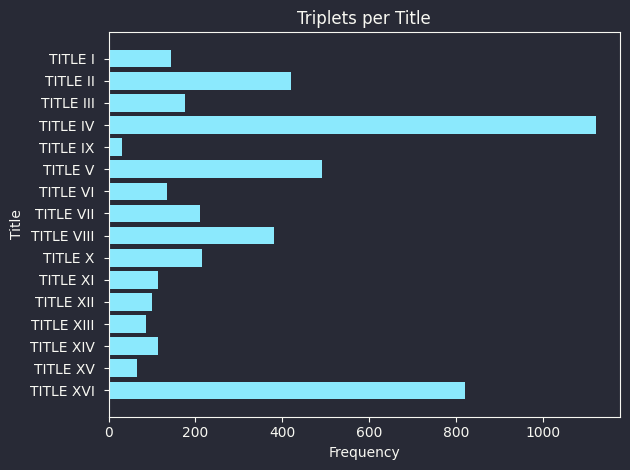

In [15]:
title_freq = triplets_df_all.groupby("Title", as_index=False)[["triplets_list"]].count().rename(columns={"triplets_list": "Frequency"})
title_freq["Title"] = title_freq["Title"].apply(lambda x: x.split('\n', 1)[0])



plt.style.use(matplotx.styles.dracula)
# plt.style.use('classic')
fig, ax = plt.subplots()

# ax.barh(title_freq["Title"], title_freq["Frequency"] / title_freq["Frequency"].sum())
ax.barh(title_freq["Title"], title_freq["Frequency"])
# ax.set_xscale("log") 
ax.invert_yaxis()
ax.set_ylabel('Title')
ax.set_xlabel('Frequency')
ax.set_title("Triplets per Title")

plt.tight_layout()
# ax.tick_params(axis='y', labelsize=8)

plt.show()

## Reduce each Relation (Verb) element of each triplet, to each lemma 

In [116]:
example_list = triplets_df_all.iloc[850,5]

In [34]:
# English pipelines include a rule-based lemmatizer
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")
# print(lemmatizer.mode)  # 'rule'

# doc = nlp("respecting")
# print(" ".join([token.lemma_ for token in doc]))
# ['I', 'be', 'read', 'the', 'paper', '.']

def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def lemmatize_sec_element(triplet):
    triplet[1] = lemmatize(triplet[1])
    return triplet 

In [55]:
lemmatize("respecting")
    

'respect'

In [35]:
triplets_df_all['triplets_list'] = triplets_df_all['triplets_list'].apply(lemmatize_sec_element)

## Bar plot - Compare Triplets Frequency Before & After Lemmatization

In [36]:
triplets_df_all.iloc[1555,5]

['this', 'be consider', ' as an interruption of the limitation period']

In [121]:
triplets_df_all.iloc[1831,5]

['the internal auditor',
 'shall enjoy',
 'complete independence in the conduct of the audits']

In [37]:
triplets_df_all["head"] = triplets_df_all["triplets_list"].apply(lambda x: x[0].strip())
triplets_df_all["relation"] = triplets_df_all["triplets_list"].apply(lambda x: x[1].strip())
triplets_df_all["tail"] = triplets_df_all["triplets_list"].apply(lambda x: x[2].strip())


In [66]:

# title_freq_2

,Title,Frequency
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",145
1,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,421
2,TITLE III \nESTABLISHMENT AND STRUCTURE OF THE...,177
3,TITLE IV \nBUDGET IMPLEMENTATION,1122
4,TITLE IX \nPRIZES,31
5,TITLE V \nCOMMON RULES,492
6,TITLE VI \nINDIRECT MANAGEMENT,135
7,TITLE VII \nPROCUREMENT AND CONCESSIONS,211
8,TITLE VIII \nGRANTS,380
9,"TITLE X \nFINANCIAL INSTRUMENTS, BUDGETARY GUA...",215


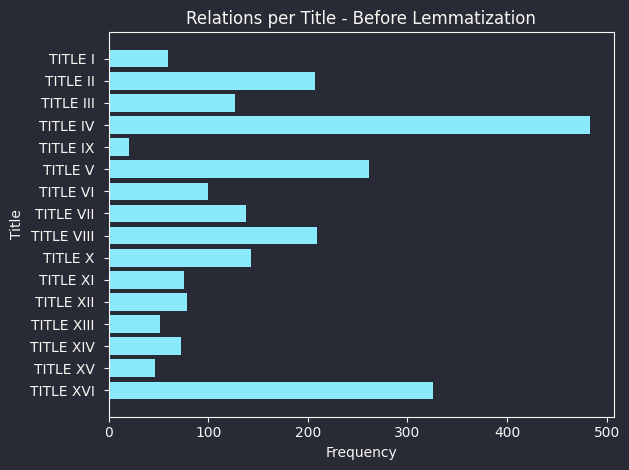

In [111]:

title_freq_2 = triplets_df_all.groupby("Title", as_index=False)[["relation"]].nunique().rename(columns={"relation": "Frequency"})
title_freq_2["Title"] = title_freq_2["Title"].apply(lambda x: x.split('\n', 1)[0])



plt.style.use(matplotx.styles.dracula)
# plt.style.use('classic')
fig, ax = plt.subplots()

ax.barh(title_freq_2["Title"], title_freq_2["Frequency"])
# ax.barh(title_freq_2["Title"], title_freq_2["Frequency"] / title_freq_2["Frequency"].sum())
ax.invert_yaxis()
ax.set_ylabel('Title')
ax.set_xlabel('Frequency')
ax.set_title("Relations per Title - Before Lemmatization")

plt.tight_layout()
# ax.tick_params(axis='y', labelsize=8)

plt.show()



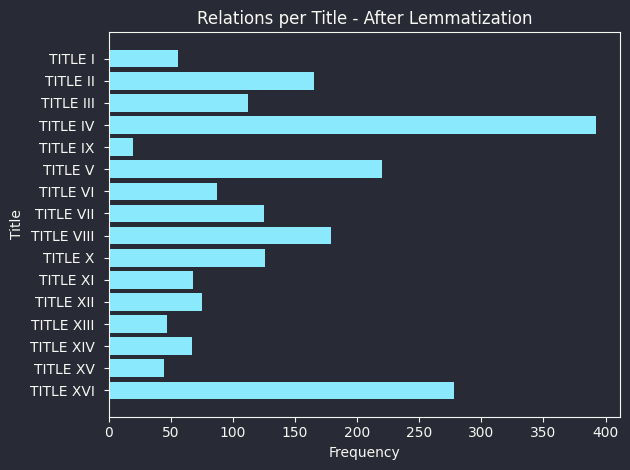

In [114]:
title_freq_2 = triplets_df_all.groupby("Title", as_index=False)[["relation"]].nunique().rename(columns={"relation": "Frequency"})
title_freq_2["Title"] = title_freq_2["Title"].apply(lambda x: x.split('\n', 1)[0])



plt.style.use(matplotx.styles.dracula)
# plt.style.use('classic')
fig, ax = plt.subplots()

ax.barh(title_freq_2["Title"], title_freq_2["Frequency"])
# ax.barh(title_freq_2["Title"], title_freq_2["Frequency"] / title_freq_2["Frequency"].sum())
ax.invert_yaxis()
ax.set_ylabel('Title')
ax.set_xlabel('Frequency')
ax.set_title("Relations per Title - After Lemmatization")

plt.tight_layout()
# ax.tick_params(axis='y', labelsize=8)

plt.show()

In [16]:
triplets_df_all

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[this regulation, lays, the rules for the esta...",False,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[applicant, means, a natural person or an enti...",False,True
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[who, has submitted, an application in a grant...",False,True
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[application document, means, a tender a reque...",False,False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[award procedure, means, a procurement procedu...",False,False
...,...,...,...,...,...,...,...,...
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[the information on the estimated amount of as...,False,True


## Identify triplets were the Head (Subject) element IS a stopword, Head=stopword

In [ ]:
triplets_df_all

### Use spaCy's list of stopwords

In [38]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS 

In [41]:
stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

### Create, Apply and Remove Triplets where Head(Subject) = stopword

- 11.68 %  of the triplets have the S part of the SVO triplet equal to a stopword

In [40]:
def detect_stopwords(head_text):
    k = False
    for stopword in stop_words:
        if stopword == head_text:
            k = True
    return k


In [42]:
triplets_df_all["is_stopword"] = triplets_df_all["head"].apply(detect_stopwords)

In [43]:
triplets_df_all["is_stopword"].sum()

541

In [44]:
triplets_df_all.shape[0]

4630

In [22]:
541 / triplets_df_all.shape[0]

0.11684665226781857

In [130]:
triplets_df_all[triplets_df_all["is_stopword"]==True]

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets,head,relation,tail,is_stopword
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[who, have submit, an application in a grant a...",False,True,who,have submit,an application in a grant award procedure or i...,True
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[which, provide, a legal basis for an action a...",False,True,which,provide,a legal basis for an action and for the implem...,True
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[which, may take, any of the following forms]",False,True,which,may take,any of the following forms,True
9,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,budgetary guarantee means a legal commitment o...,budgetary guarantee means a legal commitment o...,"[that, be call, upon]",False,True,that,be call,upon,True
9,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,budgetary guarantee means a legal commitment o...,budgetary guarantee means a legal commitment o...,"[that, remain, valid for the duration of the ...",False,True,that,remain,valid for the duration of the maturity of the ...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2327,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 275 Amendments to Regulation (EU) No ...,[ the following chapter is inserted: \n‘CHAPTE...,the following chapter is inserted: chapter va ...,they shall: represent european added value re...,"[they, climate, change mitigation and adaptati...",False,True,they,climate,change mitigation and adaptation where possible,True
2338,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 276 Amendments to Regulation (EU) No ...,"[ in Article 9, the following paragraph is add...",in article 9 the following paragraph is added:...,that decision shall specify the date of that ...,"[which, be, earlier than the date of that dec...",False,True,which,be,earlier than the date of that decision adoption,True
2349,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 276 Amendments to Regulation (EU) No ...,"[ in Article 9, the following paragraph is add...",in article 30(2) the fourth subparagraph is re...,in article 30(2) the fourth subparagraph is re...,"[this, be, as a result of fault or negligence...",False,True,this,be,as a result of fault or negligence on the part...,True
2380,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 279 Transitional provisions,[ \nLegal commitments for grants implementing ...,for financial contributions from the egf inclu...,where the provisions of title viii applicable...,"[this, be, the case the provisions of title v...",False,True,this,be,the case the provisions of title viii applicab...,True


### Only keep triplets that do not have a stopword as Head

In [131]:
triplets_df_nostop =  triplets_df_all[triplets_df_all["is_stopword"]==False]
triplets_df_nostop

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets,head,relation,tail,is_stopword
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[this regulation, lay, the rules for the estab...",False,False,this regulation,lay,the rules for the establishment and the implem...,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[applicant, mean, a natural person or an entit...",False,True,applicant,mean,a natural person or an entity with or without ...,False
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[application document, mean, a tender a reques...",False,False,application document,mean,a tender a request to participate a grant appl...,False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[award procedure, mean, a procurement procedur...",False,False,award procedure,mean,a procurement procedure a grant award procedur...,False
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[basic act, mean, a legal act other than a rec...",False,True,basic act,mean,a legal act other than a recommendation or an ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True,(17) (18) (22) and (23) article 272(26)(d) art...,article,212 and 213 article 214(2),False
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True,(17) (18) (22) and (23) article 272(26)(d) art...,article,218 219 and 220,False
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[(17) (18) (22) and (23) article 272(26)(d) ar...,False,True,(17) (18) (22) and (23) article 272(26)(d) art...,shall apply,the information on the annual average of fullt...,False
2390,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 282 Entry into force and application,[ \nThis Regulation shall enter into force on ...,by way of derogation from paragraph 2 of this ...,by way of derogation from paragraph 2 of this ...,[the information on the estimated amount of as...,False,True,the information on the estimated amount of ass...,be provide,for the first time together with the draft bud...,False


## Save CSV - triplets_dataframe_clean.csv

In [ ]:
# triplets_df_nostop.to_csv('triplets_dataframe_clean.csv', index=False) 

# Additional Exploration

In [132]:
triplets_df_nostop.groupby("Title")[["relation"]].count()

,relation
Title,
"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES",118
TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,370
TITLE III \nESTABLISHMENT AND STRUCTURE OF THE BUDGET,161
TITLE IV \nBUDGET IMPLEMENTATION,1009
TITLE IX \nPRIZES,30
TITLE V \nCOMMON RULES,428
TITLE VI \nINDIRECT MANAGEMENT,116
TITLE VII \nPROCUREMENT AND CONCESSIONS,182
TITLE VIII \nGRANTS,321


In [11]:
triplets_df_nostop.groupby("Title")[["relation"]].nunique()


,relation
Title,
"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES",34
TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,149
TITLE III \nESTABLISHMENT AND STRUCTURE OF THE BUDGET,108
TITLE IV \nBUDGET IMPLEMENTATION,374
TITLE IX \nPRIZES,20
TITLE V \nCOMMON RULES,200
TITLE VI \nINDIRECT MANAGEMENT,77
TITLE VII \nPROCUREMENT AND CONCESSIONS,107
TITLE VIII \nGRANTS,165


In [5]:
triplets_df_nostop.groupby("Title")[["head"]].nunique()

,head
Title,
"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES",103
TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,218
TITLE III \nESTABLISHMENT AND STRUCTURE OF THE BUDGET,84
TITLE IV \nBUDGET IMPLEMENTATION,520
TITLE IX \nPRIZES,20
TITLE V \nCOMMON RULES,235
TITLE VI \nINDIRECT MANAGEMENT,65
TITLE VII \nPROCUREMENT AND CONCESSIONS,102
TITLE VIII \nGRANTS,194


In [23]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES ']["relation"].unique()

array(['implement', 'set', 'authorise', 'be charge', 'shall contain',
       'shall consist', 'shall cover', 'prevent', 'be commit', 'be make',
       'provide', 'be book', 'be enter', 'be', 'be authorise',
       'be adjust', 'refer', 'have reach', 'adopt', 'be approve',
       'be lay', 'be carry', 'be complete', 'have adopt', 'use', 'exceed',
       'be return', 'shall take', 'shall inform', 'state', 'be apply',
       'carry', 'commit', 'annex', 'be pay', 'cancel', 'be decommitte',
       'correspond', 'apply', 'shall examine', 'shall decide', 'belong',
       'require', 'may authorise', 'shall', 'shall enter', 'take',
       'shall submit', 'inform', 'wish', 'be give', 'shall act',
       'be exceed', 'raise', 'be draw', 'be present', 'account',
       'be establish', 'avoid', 'be calculate', 'be use',
       'shall constitute', 'participate', 'receive', 'transfer',
       'may assign', 'specify', 'shall include', 'indicate',
       'shall comprise', 'may receive', 'be show', 'be 

In [22]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES ']["head"].unique()

array(['the budget', 'the common foreign and security policy (cfsp)',
       'the appropriations authorised for the financial year',
       'commitment appropriations', 'payment appropriations',
       'paragraphs 2 and 3 of this article', 'appropriations',
       'budgetary commitments', 'all revenue and expenditure',
       'no expenditure', 'an appropriation',
       'interest generated by prefinancing payments made from the budget',
       'the appropriations entered in the budget',
       'the revenue of a financial year',
       'the own resources for the month of january of the following financial year may be made available in advance pursuant to regulation (eu euratom) no 6092014',
       'the entries in respect of the value added tax (vat) and',
       'commitments', 'the global budgetary commitments', 'payments',
       'the expenditure of the european agricultural guarantee fund (eagf)',
       'the payment order', 'the following expenditure',
       'routine administrative 

In [31]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("the commission and the other union institutions")
for token in doc:
    print(token.text,'|', token.dep_, '|', token.head.text,'|', token.head.pos_,
            [child for child in token.children])

the | det | commission | NOUN []
commission | ROOT | commission | NOUN [the, and, institutions]
and | cc | commission | NOUN []
the | det | institutions | NOUN []
other | amod | institutions | NOUN []
union | compound | institutions | NOUN []
institutions | conj | commission | NOUN [the, other, union]


In [37]:
import spacy
# from spacy.symbols import NOUN, det, compound

nlp = spacy.load("en_core_web_sm")
doc = nlp("the commission and the other union institutions")

tokens = []
for token in doc:
    tokens.append(token)

print(tokens)
# Finding a verb with a subject from below — good
# verbs = set()
for possible_subject in doc:
    if possible_subject.dep == det and possible_subject.head.pos == NOUN:
        if possible_subject.dep == 
        print(possible_subject, possible_subject.head)
# print(verbs)


[the, commission, and, the, other, union, institutions]


In [42]:
import spacy
from spacy.symbols import NOUN, det, compound

nlp = spacy.load("en_core_web_sm")
doc = nlp("the payment appropriations provided for in the relevant budget lines for the following financial year")

for possible_subject in doc:
    if possible_subject.dep == det and possible_subject.head.pos == NOUN:
        if possible_subject.dep == 
        print(possible_subject, possible_subject.head)

SyntaxError: invalid syntax (1238292535.py, line 9)

In [63]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("carryovers of noncommitted appropriations")
for chunk in doc.noun_chunks:
    print(chunk)


carryovers
noncommitted appropriations


In [20]:
relations_freq = triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES '].groupby(["relation"])["relation"].count().reset_index(name='count').sort_values(by=('count'), ascending=False) 


In [21]:
relations_freq

,relation,count
26,mean,71
11,conclude,4
28,refer,3
1,be,3
27,provide,2
4,be govern,2
13,cover,2
21,lay,2
9,be sign,2
7,be provide,2


In [10]:
relations_freq['count'].sum()

np.int64(370)

In [17]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES '][triplets_df_nostop["relation"] =='support']

C:\Users\Student\AppData\Local\Temp\ipykernel_4744\270250028.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES '][triplets_df_nostop["relation"] =='support']


,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets,head,relation,tail,is_stopword
306,TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,Article 26 Corporate sponsorship,[ \n‘Corporate sponsorship’ means an agreement...,corporate sponsorship means an agreement by wh...,corporate sponsorship means an agreement by wh...,"[a legal person, support, inkind by which]",False,True,a legal person,support,inkind by which,False


In [16]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE IV \nBUDGET IMPLEMENTATION ']["head"].unique()[0]

'the commission'

In [31]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("the commission and other union institutions")
for token in doc: 
    print(token, " | ", 
          spacy.explain(token.pos_)) 

the  |  determiner
commission  |  noun
and  |  coordinating conjunction
other  |  adjective
union  |  noun
institutions  |  noun


In [34]:
import spacy
from spacy.symbols import NOUN

nlp = spacy.load("en_core_web_sm")
doc = nlp("the commission and other union institutions")

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.pos == NOUN and possible_subject.head.pos == NOUN:
        verbs.add(possible_subject.head)
print(verbs)

{institutions, commission}


In [12]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE IV \nBUDGET IMPLEMENTATION ']["tail"].unique()

array(['the revenue and expenditure of the budget in accordance with this regulation under the commission',
       'responsibility', 'within the limits of the appropriations',
       'with the commission',
       'in accordance with the principle of sound financial management',
       'that for the purposes of safeguarding the financial interests of the union their personal data may be transferred to internal audit services to the court of auditors or to the european antifraud office (olaf) and between authorising officers of the commission and the executive agencies referred to in article 69 of this regulation and the union bodies referred to in articles 70 and 71 of this regulation',
       'for the purposes of safeguarding the financial interests of the union to internal audit services to the court of auditors or to the european antifraud office (olaf)',
       'to in articles 70 and 71 of this regulation',
       'in the budget for any union action', 'only',
       'by way of derog

In [137]:
triplets_df_nostop.to_csv('triplets_dataframe_clean.csv', index=False) 

## Filter heads and relations. Count how frequency of entities and relations per title. What are the most frequent ? 

In [2]:

import pandas as pd
import ast
import spacy
import re
import claucy

In [3]:
# Load triplets dataframe 
triplets_df_nostop= pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\triplets_dataframe_clean.csv')

In [4]:
def convert_to_list(column):
    return column.apply(ast.literal_eval)

triplets_df_nostop['Content'] = convert_to_list(triplets_df_nostop['Content'])
triplets_df_nostop['triplets_list'] = convert_to_list(triplets_df_nostop['triplets_list'])

In [5]:
triplets_df_nostop.head()

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets,head,relation,tail,is_stopword
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[this regulation, lay, the rules for the estab...",False,False,this regulation,lay,the rules for the establishment and the implem...,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[applicant, mean, a natural person or an entit...",False,True,applicant,mean,a natural person or an entity with or without ...,False
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[application document, mean, a tender a reques...",False,False,application document,mean,a tender a request to participate a grant appl...,False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[award procedure, mean, a procurement procedur...",False,False,award procedure,mean,a procurement procedure a grant award procedur...,False
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[basic act, mean, a legal act other than a rec...",False,True,basic act,mean,a legal act other than a recommendation or an ...,False


In [6]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES ']["relation"].unique()

array(['implement', 'set', 'authorise', 'be charge', 'shall contain',
       'shall consist', 'shall cover', 'prevent', 'be commit', 'be make',
       'provide', 'be book', 'be enter', 'be', 'be authorise',
       'be adjust', 'refer', 'have reach', 'adopt', 'be approve',
       'be lay', 'be carry', 'be complete', 'have adopt', 'use', 'exceed',
       'be return', 'shall take', 'shall inform', 'state', 'be apply',
       'carry', 'commit', 'annex', 'be pay', 'cancel', 'be decommitte',
       'correspond', 'apply', 'shall examine', 'shall decide', 'belong',
       'require', 'may authorise', 'shall', 'shall enter', 'take',
       'shall submit', 'inform', 'wish', 'be give', 'shall act',
       'be exceed', 'raise', 'be draw', 'be present', 'account',
       'be establish', 'avoid', 'be calculate', 'be use',
       'shall constitute', 'participate', 'receive', 'transfer',
       'may assign', 'specify', 'shall include', 'indicate',
       'shall comprise', 'may receive', 'be show', 'be 

In [7]:
triplets_df_nostop.groupby("Title")[["head"]].nunique()

,head
Title,
"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES",103
TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,218
TITLE III \nESTABLISHMENT AND STRUCTURE OF THE BUDGET,84
TITLE IV \nBUDGET IMPLEMENTATION,520
TITLE IX \nPRIZES,20
TITLE V \nCOMMON RULES,235
TITLE VI \nINDIRECT MANAGEMENT,65
TITLE VII \nPROCUREMENT AND CONCESSIONS,102
TITLE VIII \nGRANTS,194


In [9]:
triplets_df_nostop.groupby("Title")[["relation"]].nunique()

,relation
Title,
"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES",34
TITLE II \nBUDGET AND BUDGETARY PRINCIPLES,149
TITLE III \nESTABLISHMENT AND STRUCTURE OF THE BUDGET,108
TITLE IV \nBUDGET IMPLEMENTATION,374
TITLE IX \nPRIZES,20
TITLE V \nCOMMON RULES,200
TITLE VI \nINDIRECT MANAGEMENT,77
TITLE VII \nPROCUREMENT AND CONCESSIONS,107
TITLE VIII \nGRANTS,165


In [10]:
nlp = spacy.load("en_core_web_sm")

def tokens_len(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token)
    return len(tokens)

def contains_nouns(text):
    doc = nlp(text)
    k = False
    tags = []
    for token in doc:
        tags.append(spacy.explain(token.pos_))
    if "noun" in tags:
            k=True
    return k

In [29]:
relations_freq = triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES '].groupby(["relation"])["relation"].count().reset_index(name='count').sort_values(by=('count'), ascending=False)
relations_freq 

,relation,count
108,refer,31
42,be make,28
11,be,27
31,be enter,12
23,be commit,8
...,...,...
141,specify,1
144,support,1
143,subdivide,1
142,state,1


In [12]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES ']

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets,head,relation,tail,is_stopword
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[this regulation, lay, the rules for the estab...",False,False,this regulation,lay,the rules for the establishment and the implem...,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[applicant, mean, a natural person or an entit...",False,True,applicant,mean,a natural person or an entity with or without ...,False
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[application document, mean, a tender a reques...",False,False,application document,mean,a tender a request to participate a grant appl...,False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[award procedure, mean, a procurement procedur...",False,False,award procedure,mean,a procurement procedure a grant award procedur...,False
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[basic act, mean, a legal act other than a rec...",False,True,basic act,mean,a legal act other than a recommendation or an ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
113,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,works contract means a contract covering eithe...,works contract means a contract covering eithe...,[the execution or both the execution and desig...,False,True,the execution or both the execution and design...,directive,201424eu or the realisation by whatever means ...,False
114,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 3 Compliance of secondary legislation...,[ \nProvisions concerning the implementation o...,provisions concerning the implementation of th...,provisions concerning the implementation of th...,[provisions concerning the implementation of t...,False,False,provisions concerning the implementation of th...,shall comply,with the budgetary principles set out in title ii,False
115,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,unless otherwise provided in this regulation c...,unless otherwise provided in this regulation c...,"[no 118271 ( 1 ), provide, otherwise in this ...",False,True,no 118271 ( 1 ),provide,otherwise in this regulation council regulatio...,False
116,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...","Article 4 Periods, dates and time limits",[\nUnless otherwise provided in this Regulatio...,unless otherwise provided in this regulation c...,unless otherwise provided in this regulation c...,"[no 118271 ( 1 ), shall apply, to the deadlin...",False,True,no 118271 ( 1 ),shall apply,to the deadlines set out in this regulation,False


In [124]:
relations_freq = triplets_df_nostop.groupby(["relation"])["relation"].count().reset_index(name='count').sort_values(by=('count'), ascending=False)
relations_freq["relative_freq"] = (relations_freq["count"] / relations_freq["count"].sum()) * 100
relations_freq

,relation,count,relative_freq
36,be,366,8.950844
601,refer,276,6.749817
240,be replace,110,2.690144
187,be make,75,1.834189
555,mean,74,1.809733
...,...,...,...
815,should remain,1,0.024456
814,should enable,1,0.024456
593,reach,1,0.024456
812,shall withdraw,1,0.024456


In [126]:
relations_freq.groupby("count").count()

,relation,relative_freq
count,,
1,376,376
2,176,176
3,76,76
4,43,43
5,34,34
6,31,31
7,17,17
8,13,13
9,16,16


In [121]:
relations_freq = triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES '].groupby(["relation"])["relation"].count().reset_index(name='count').sort_values(by=('count'), ascending=False)
relations_freq["relative_freq"] = (relations_freq["count"] / relations_freq["count"].sum()) * 100
relations_freq 

,relation,count,relative_freq
108,refer,31,8.378378
42,be make,28,7.567568
11,be,27,7.297297
31,be enter,12,3.243243
23,be commit,8,2.162162
...,...,...,...
141,specify,1,0.270270
144,support,1,0.270270
143,subdivide,1,0.270270
142,state,1,0.270270


In [122]:
relations_freq.groupby("count").count()

,relation,relative_freq
count,,
1,90,90
2,27,27
3,10,10
4,8,8
5,3,3
6,2,2
7,1,1
8,4,4
12,1,1


In [119]:
relations_freq.groupby("relative_freq")['count'].count()

relative_freq
0.270270    90
0.540541    27
0.810811    10
1.081081     8
1.351351     3
1.621622     2
1.891892     1
2.162162     4
3.243243     1
7.297297     1
7.567568     1
8.378378     1
Name: count, dtype: int64

In [79]:
import seaborn as sns

INFO:matplotlib.font_manager:generated new fontManager


<Axes: xlabel='count', ylabel='relation'>

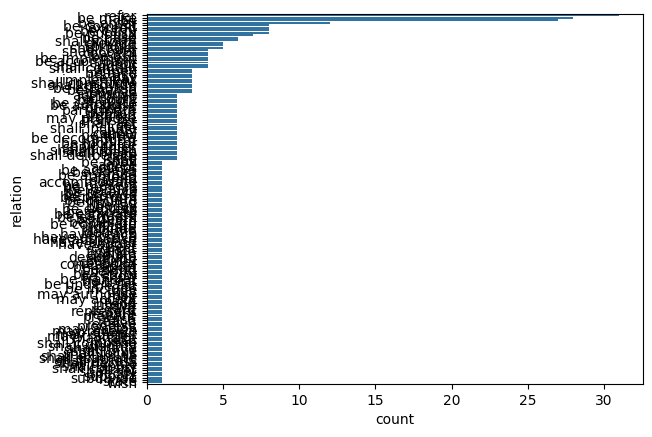

In [123]:
sns.barplot(relations_freq, y="relation", x="count")

<Axes: ylabel='count'>

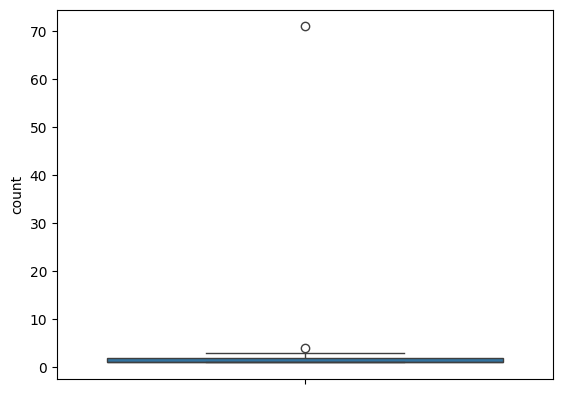

In [95]:
sns.boxplot(data=relations_freq, y="count")

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\Student\AppData\Local\Temp\ipykernel_4744\2053893148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(y='count', data=relations_freq, palette="Set3")


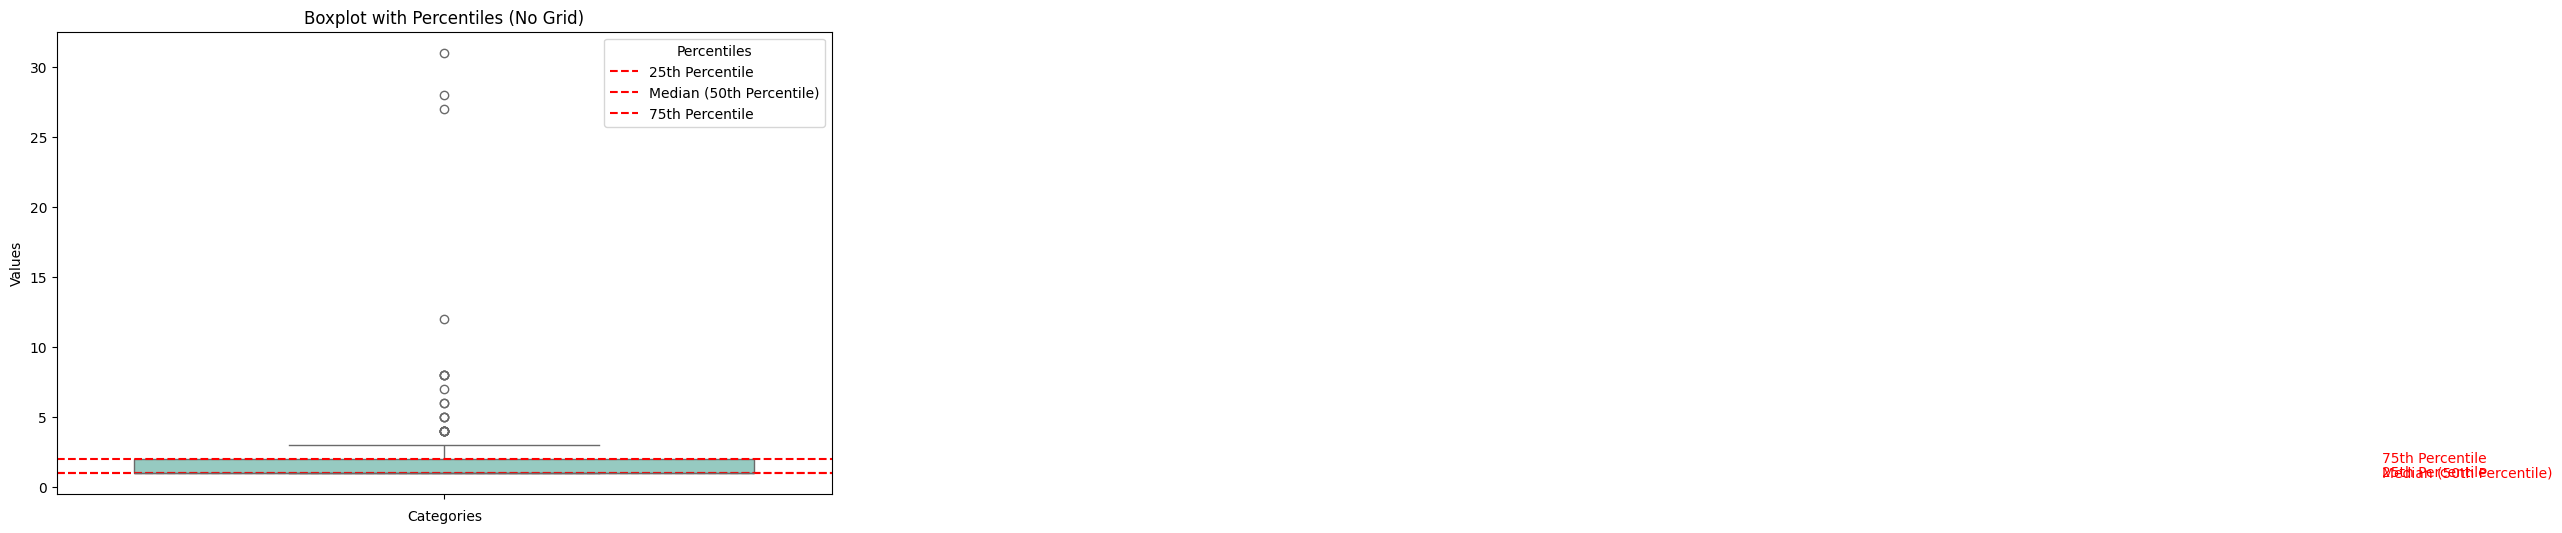

In [92]:
# Create a boxplot
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(y='count', data=relations_freq, palette="Set3")

# Calculate percentiles (25th, 50th, 75th)
percentiles = np.percentile(relations_freq['count'], [25, 50, 75])
percentile_labels = ['25th Percentile', 'Median (50th Percentile)', '75th Percentile']

# Add horizontal lines for percentiles
for p, label in zip(percentiles, percentile_labels):
    plt.axhline(y=p, color='red', linestyle='--', label=label)
    # Annotate the percentile on the right side
    plt.text(x=2.5, y=p, s=label, color='red', va='center', fontsize=10)

# Customize the plot
plt.title('Boxplot with Percentiles (No Grid)')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.legend(title='Percentiles')

# Show the plot
plt.show()

In [75]:
relations_freq["count"].quantile(0.5)

np.float64(2.0)

In [76]:
triplets_df_nostop[triplets_df_nostop["relation"] == 'should remain']

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets,head,relation,tail,is_stopword
3950,TITLE XVI \nINFORMATION REQUESTS AND DELEGATED...,Article 274 Amendments to Regulation (EU) No ...,"[ in recital 24, the first sentence is replace...",in recital 24 the first sentence is replaced b...,in recital 24 the first sentence is replaced b...,"[the member states, should remain, in recital...",False,True,the member states,should remain,in recital 24 the first sentence is replaced b...,False


In [3]:
import spacy
from spacy.symbols import NOUN, det

nlp = spacy.load("en_core_web_sm")
doc = nlp("the payment appropriations provided for in the relevant budget lines for the following financial year")

for possible_subject in doc:
    if possible_subject.dep == det and possible_subject.head.pos == NOUN:
        print(possible_subject, possible_subject.head)

the appropriations
the lines
the year


In [4]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("the payment appropriations provided for in the relevant budget lines for the following financial year")
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])


the det appropriations NOUN []
payment compound appropriations NOUN []
appropriations ROOT appropriations NOUN [the, payment, provided]
provided acl appropriations NOUN [for, in, for]
for prep provided VERB []
in prep provided VERB [lines]
the det lines NOUN []
relevant amod lines NOUN []
budget compound lines NOUN []
lines pobj in ADP [the, relevant, budget]
for prep provided VERB [year]
the det year NOUN []
following amod year NOUN []
financial amod year NOUN []
year pobj for ADP [the, following, financial]


In [12]:
from spacy import displacy
from IPython.display import Image, display
doc = nlp("the expenditure of the european agricultural guarantee fund (eagf)")
displacy.render(doc, options={"fine_grained": True})
display(Image("displacy_output.png"))



FileNotFoundError: No such file or directory: 'displacy_output.png'

FileNotFoundError: No such file or directory: 'displacy_output.png'

<IPython.core.display.Image object>

In [13]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("the expenditure of the european agricultural guarantee fund (eagf)")
for chunk in doc.noun_chunks:
    print(chunk)

the expenditure
the european agricultural guarantee fund
eagf


In [20]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE II \nBUDGET AND BUDGETARY PRINCIPLES ']["head"].unique()

array(['the budget', 'the common foreign and security policy (cfsp)',
       'the appropriations authorised for the financial year',
       'commitment appropriations', 'payment appropriations',
       'paragraphs 2 and 3 of this article', 'appropriations',
       'budgetary commitments', 'all revenue and expenditure',
       'no expenditure', 'an appropriation',
       'interest generated by prefinancing payments made from the budget',
       'the appropriations entered in the budget',
       'the revenue of a financial year',
       'the own resources for the month of january of the following financial year may be made available in advance pursuant to regulation (eu euratom) no 6092014',
       'the entries in respect of the value added tax (vat) and',
       'commitments', 'the global budgetary commitments', 'payments',
       'the expenditure of the european agricultural guarantee fund (eagf)',
       'the payment order', 'the following expenditure',
       'routine administrative 

In [6]:
!pip install cairosvg


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("all revenue and expenditure")
for chunk in doc.noun_chunks:
    print(chunk)


all revenue
expenditure


In [14]:
triplets_df_nostop[triplets_df_nostop["Title"]=='TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES ']["relation"]

0               lay
1              mean
2              mean
3              mean
4              mean
           ...     
113       directive
114    shall comply
115         provide
116     shall apply
117              be
Name: relation, Length: 118, dtype: object